In [109]:
import os
import PIL
import torch
import urllib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
# from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101, deeplabv3_mobilenet_v3_large
# from torchvision.models.segmentation import (
#                                              DeepLabV3_ResNet50_Weights,
#                                              DeepLabV3_ResNet101_Weights,
#                                              DeepLabV3_MobileNet_V3_Large_Weights
#                                              )

In [110]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True)
model.eval()

Using cache found in C:\Users\boris/.cache\torch\hub\pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [111]:
load_url = False
folder = "test_images/"

In [112]:
if load_url:
    url, filename = ("hond.png", "deeplab1.png")
    try: urllib.URLopener().retrieve(url, filename)
    except: urllib.request.urlretrieve(url, filename)

In [113]:
def output_image(output_predictions, filename):
    # Open de originele afbeelding
    input_image = Image.open(folder + filename)

    # Resize de mask naar de grootte van de input_image
    mask = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size, resample=Image.NEAREST)

    # Converteer mask naar een numpy array voor verwerking
    mask_array = np.array(mask)

    # Maak een RGB-versie van de mask met behulp van de kleurenpalet
    mask_rgb = Image.new("RGB", mask.size)
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")

    # Pas de kleuren toe op de mask
    for i in range(21):  # Pas aan op basis van het aantal klassen in je model
        class_mask = (mask_array == i)
        if not np.any(class_mask):  # Als de klasse niet voorkomt in de mask, ga verder naar de volgende
            continue
        class_image = Image.fromarray(np.uint8(class_mask) * 255).convert("L")
        colored_mask = Image.new("RGB", mask.size, color=tuple(colors[i]))
        mask_rgb.paste(colored_mask, mask=class_image)

    # Converteer de mask naar RGBA voor transparantie
    mask_rgba = mask_rgb.convert("RGBA")
    datas = mask_rgba.getdata()

    newData = []
    for item in datas:
        if item[0] != 0 or item[1] != 0 or item[2] != 0:
            newData.append(item[:-1] + (128,))  # Behoud de kleur, maar voeg transparantie toe
        else:
            newData.append((255, 255, 255, 0))  # Volledig transparant

    mask_rgba.putdata(newData)

    # Combineer de mask met de originele afbeelding
    input_image_rgba = input_image.convert("RGBA")
    combined = Image.alpha_composite(input_image_rgba, mask_rgba)

    # Toon en sla de gecombineerde afbeelding op
    plt.imshow(combined)
    plt.axis('off')
    plt.show()


In [114]:
def run_model(folder, filename):
    input_image = Image.open(folder + filename)
    plt.imshow(input_image)

    input_image = input_image.convert("RGB")
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    output_image(output_predictions, filename)

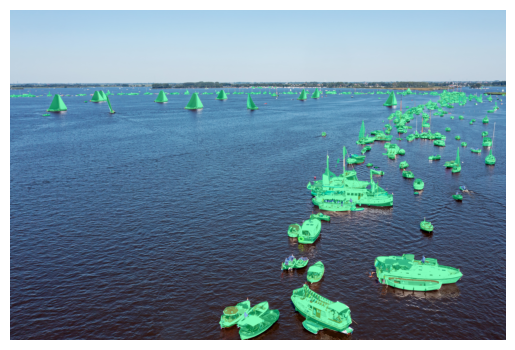

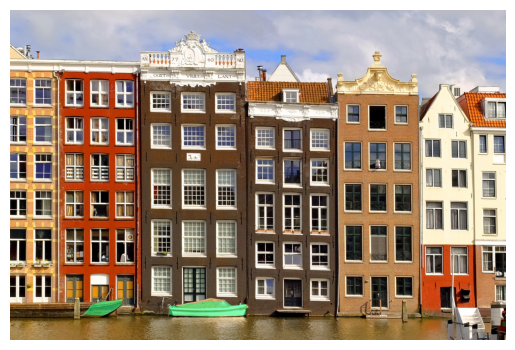

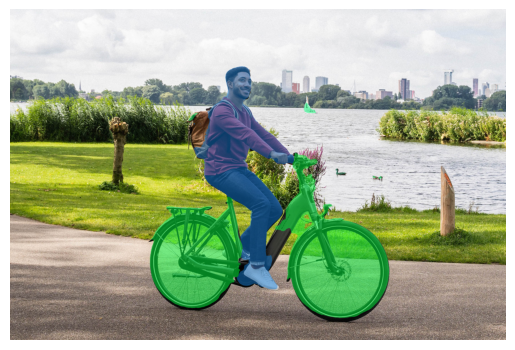

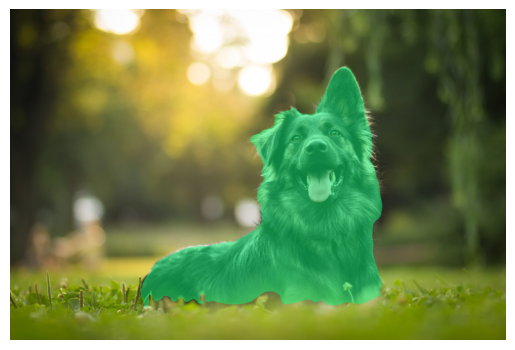

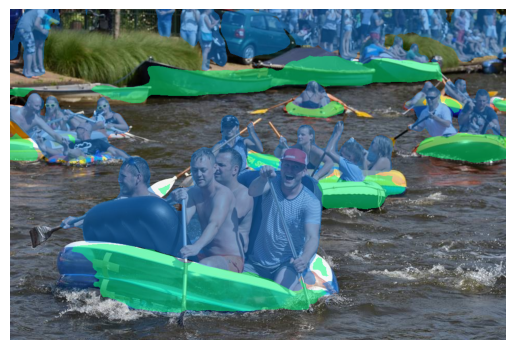

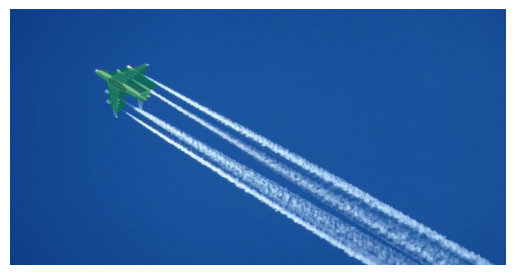

In [117]:
files = os.listdir(folder)

for filename in files:
    if filename.endswith('.png') or filename.endswith('.jpg'):
        run_model(filename)